<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in data</a></span><ul class="toc-item"><li><span><a href="#Alternate-MW-calculations,-dataframes" data-toc-modified-id="Alternate-MW-calculations,-dataframes-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Alternate MW calculations, dataframes</a></span></li></ul></li><li><span><a href="#Apply-WF-bins" data-toc-modified-id="Apply-WF-bins-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Apply WF bins</a></span></li></ul></li><li><span><a href="#Model-setup" data-toc-modified-id="Model-setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model setup</a></span></li><li><span><a href="#SVC-RBF-Models" data-toc-modified-id="SVC-RBF-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SVC-RBF Models</a></span><ul class="toc-item"><li><span><a href="#ENM-only" data-toc-modified-id="ENM-only-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>ENM-only</a></span><ul class="toc-item"><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Permutation-test" data-toc-modified-id="Permutation-test-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Permutation test</a></span></li><li><span><a href="#Feature-comparison" data-toc-modified-id="Feature-comparison-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Feature comparison</a></span></li></ul></li><li><span><a href="#Organics-only" data-toc-modified-id="Organics-only-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Organics-only</a></span></li><li><span><a href="#Randomly-augmented-data" data-toc-modified-id="Randomly-augmented-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Randomly augmented data</a></span></li><li><span><a href="#Matching-(unsupervised)-augmented-data" data-toc-modified-id="Matching-(unsupervised)-augmented-data-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Matching (unsupervised) augmented data</a></span></li><li><span><a href="#Matching-(supervised)-augmented-data" data-toc-modified-id="Matching-(supervised)-augmented-data-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Matching (supervised) augmented data</a></span></li></ul></li><li><span><a href="#Random-Forest-Models" data-toc-modified-id="Random-Forest-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Forest Models</a></span><ul class="toc-item"><li><span><a href="#ENM-only" data-toc-modified-id="ENM-only-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>ENM-only</a></span></li><li><span><a href="#Randomly-augmented-data" data-toc-modified-id="Randomly-augmented-data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Randomly augmented data</a></span></li><li><span><a href="#Matching-(unsupervised)-augmented-data" data-toc-modified-id="Matching-(unsupervised)-augmented-data-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Matching (unsupervised) augmented data</a></span></li><li><span><a href="#Matching-(supervised)-augmented-data" data-toc-modified-id="Matching-(supervised)-augmented-data-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Matching (supervised) augmented data</a></span></li></ul></li><li><span><a href="#Performance-Results" data-toc-modified-id="Performance-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance Results</a></span><ul class="toc-item"><li><span><a href="#SVC-RBF" data-toc-modified-id="SVC-RBF-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>SVC-RBF</a></span><ul class="toc-item"><li><span><a href="#Permutation-test" data-toc-modified-id="Permutation-test-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Permutation test</a></span></li><li><span><a href="#Significance-testing" data-toc-modified-id="Significance-testing-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Significance testing</a></span></li></ul></li><li><span><a href="#RFC" data-toc-modified-id="RFC-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>RFC</a></span></li></ul></li></ul></div>

# Code setup

In [40]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To suppress warning output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(42)

In [41]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.titlesize'] = 'x-large' #16
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

In [42]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [43]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt
importlib.reload(blt);

Figure directory exists.


# Data

## Read in data

In [44]:
# Target (ENM) data

# Read in ENM feature data
X_enm = pd.read_csv("./data/ENM-preprocessed-feats.csv", 
                    sep='\t', header='infer', index_col=0)
# Read in ENM labels (maximum_weight_fraction)
y_enm = pd.read_csv("./data/ENM-clean.csv", 
                    sep=',', header='infer', usecols=[4])
print('X_enm shape:', X_enm.shape)
print('y_enm shape:', y_enm.shape)

X_enm shape: (112, 35)
y_enm shape: (112, 1)


In [45]:
# Source (bulk organics) data

# Read in source feature data
X_source = pd.read_csv("./data/organics-preprocessed-feats.csv", 
                       sep='\t', header='infer', index_col=0)
# Read in source labels (maximum_weight_fraction)
y_source = pd.read_csv("./data/organics-preprocessed-WF.csv", 
                       sep='\t', header='infer', index_col=0)
y_source.index = X_source.index
print('X_source shape:', X_source.shape)
print('y_source shape:', y_source.shape)

X_source shape: (16439, 35)
y_source shape: (16439, 1)


In [46]:
# View ENM feature df
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_logdensity,fagg_absorbent_opacifier,fagg_brightener_viscositymodifier,fagg_filler_humectant,func_UVstabilizer,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,0.626340,0.0,0.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,63.546,1083.00,0.952308,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,65.370,419.53,0.853698,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0


In [23]:
# Read in previous model evaluation results tables
results_svc = pd.read_csv("./data/results-SVC.csv", sep='\t', na_values='nan')
results_rfc = pd.read_csv("./data/results-RFC.csv", sep='\t')
results_permute = np.loadtxt('./data/results-permutation-SVC.txt')

### Alternate MW calculations, dataframes

Here, we explore using "diameter" as an alternative feature for MW (which must also replace density, as this is used in the equation).

In [60]:
def diameter(MW, density, isorganic=True):
    
    if isorganic:
        diam = (MW / density) ** (1./3)
    else:
        diam = ((6 * MW) / (math.pi * density)) ** (1./3)
        
    return diam

In [ ]:
density = X_enm
cprp_diamENM = diameter(X_enm['cprp_MW'], X_enm['cprp_logdensity']

## Apply WF bins

Labels (continuous WF data) will be binned into low (0.0-0.0001), medium (0.0001-0.01) and high (0.01-1.0) categories.

In [24]:
# Apply bins to ENM and organics data
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))

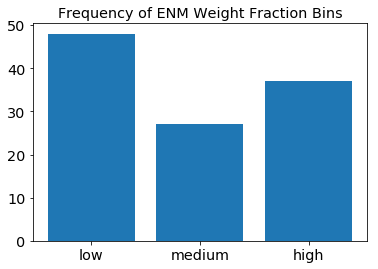

Label bin:  [0 1 2]
Count    :  [48 27 37]
Frequency:  [0.43, 0.24, 0.33]


In [25]:
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition='ENM')

The medium WF bin has the least number of samples. This is important for evaluating models later on; the smallest bin size will be used for the number of cross validation folds so that it's essentially "leave-one-out" CV. This approach is, for the most part, considered unbiased.

https://stats.stackexchange.com/questions/154830/10-fold-cross-validation-vs-leave-one-out-cross-validation

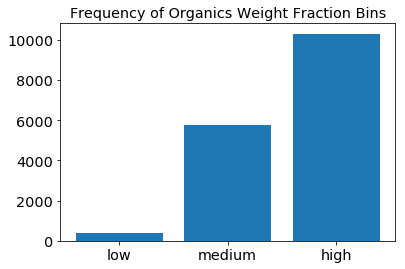

Label bin:  [0 1 2]
Count    :  [  381  5746 10312]
Frequency:  [0.02, 0.35, 0.63]


In [26]:
# View bar plot of Organics WF bins
blt.bar_graph_bins(bin_source, data_composition='Organics')

# Model setup

The main prediction model function, <b>blt.model_opt_exe</b>, optimizes, executes and evaluates a classifier using stratified CV. It has the option to augment the training data within the pipeline. It is defined in an external file called at the beginning of this script.

The first part of the <b>blt.model_opt_exe</b> function runs a pipeline that normalizes features on a 0 to 1 scale then performs data augmentation and runs a classifer (SVC-RBF or RFC) using leave-one-out cross validation. Model parameters are optimized using a custom parameter grid search, with the optional aid of plots to visualize accuracy over the grid.

The final pipeline (trained using augmented data) is tested on the original ENM data using stratified cross-validation with n_folds = n_samples in the smallest WF bin--essentially leave-one-out CV (discussed earlier). A confusion matrix summarizes accuracy results according to each WF bin ("class"). The average normalized accuracy across all bins is then calculated from the confusion matrix and written to a results table for every data set.

# SVC-RBF Models

## ENM-only

### Baseline model

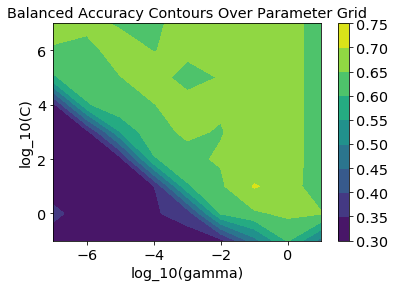

Random state:	 28
Best parameters: {'C': 10.0, 'gamma': 0.1}
Max opt. balanced accuracy: 0.704
Avg. balanced accuracy:     0.721
Normalized Confusion Matrix
[[0.81 0.15 0.04]
 [0.33 0.59 0.07]
 [0.08 0.16 0.76]]


0.7206164497831166

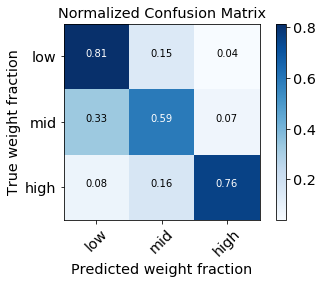

In [24]:
# Single trial SVC-RBF, balanced accuracy
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=28, 
                  save_fig_name='enm-only', 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=True, 
                  use_balanced_accu=True, # Balanced accuracy
                  param_grid=param_grid)

In [38]:
# 30 trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[1,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params, 
                                           print_results=True)

Avg accuracy:     0.713
Median accuracy:  0.71
StdDev accuracy:  0.009
Numer of trials:  30
Results:  [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]


(0.713, 0.009)

In [51]:
# 30 trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[1,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params, 
                                           print_results=True)

Avg accuracy:     0.713
Median accuracy:  0.71
StdDev accuracy:  0.009
Numer of trials:  30
Results:  [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]


In [27]:
# 50 trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=50, 
                 model_params=model_params, 
                 print_results=True)

Avg accuracy:     0.713
Median accuracy:  0.708
StdDev accuracy:  0.01
Numer of trials:  50
Results:  [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7, 0.72, 0.71, 0.72, 0.74, 0.71, 0.71, 0.7, 0.72, 0.71, 0.71, 0.71, 0.73, 0.72, 0.71, 0.71, 0.72, 0.73, 0.73, 0.71, 0.69]


(0.713, 0.01)

In [13]:
# Save balanced accuracy results for later evaluation
base_distrib = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 
                0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 
                0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7, 
                0.72, 0.71, 0.72, 0.74, 0.71, 0.71, 0.7, 0.72, 0.71, 0.71, 
                0.71, 0.73, 0.72, 0.71, 0.71, 0.72, 0.73, 0.73, 0.71, 0.69]

In [29]:
# 50 trials SVC-RBF, normal accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': False, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=50, model_params=model_params)

Avg accuracy:     0.711
Median accuracy:  0.707
StdDev accuracy:  0.01
Numer of trials:  50


(0.711, 0.01)

Balanced accuracy performed negligibly better, but makes more sense to use given the imbalance of data between WF bins. Therefore, it will be used throughout.

### Permutation test

The following tests are performed with randomly permuted labels (ENM data only).

In [14]:
# TODO: Decorator allows selective application of completion "pings"
notify_on_complete = blt.CompletionNotifier(blt.ping_notify)

In [15]:
@notify_on_complete
def perm_test(num_trials, classifier, model_params):
    seed_set = np.random.choice(np.arange(0,100), 
                                size=num_trials, replace=False)
    results_permute = np.empty(seed_set.size)
    for idx, s in enumerate(seed_set):
        with blt.HiddenPrints():
            bin_enm_permute = np.random.RandomState(seed=s).permutation(bin_enm)
            results_permute[idx] = blt.model_opt_exe(classifier=classifier, 
                                                     aug_type='none', 
                                                     k=0, 
                                                     feat_data=X_enm, 
                                                     bin_data=bin_enm_permute,
                                                     param_grid=param_grid);
    mu_permute = results_permute.mean()
    sigma_permute = results_permute.std()
    print("Avg accuracy:    ", mu_permute)
    print("Median accuracy: ", np.median(results_permute))
    print("StdDev accuracy: ", sigma_permute)
    print("Numer of trials: ", num_trials)
    print("Results: ", results_permute)
    return mu_permute, sigma_permute

In [36]:
# Run permutation tests over a number of trials, "num_trials"
num_trials = 100
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
mu_permute, sigma_permute = perm_test(100, 'svc', model_params=param_grid)

Avg accuracy:     0.4033948531865199
Median accuracy:  0.4043105605605606
StdDev accuracy:  0.04740425911893349
Numer of trials:  100
Results:  [0.36 0.39 0.39 0.45 0.4  0.42 0.32 0.48 0.42 0.43 0.34 0.4  0.38 0.47
 0.34 0.34 0.41 0.34 0.34 0.42 0.48 0.35 0.37 0.41 0.39 0.38 0.46 0.47
 0.48 0.39 0.45 0.4  0.43 0.42 0.41 0.47 0.41 0.34 0.38 0.38 0.39 0.35
 0.46 0.44 0.38 0.35 0.42 0.37 0.33 0.44 0.39 0.44 0.47 0.45 0.39 0.35
 0.43 0.5  0.34 0.38 0.34 0.43 0.34 0.36 0.37 0.54 0.37 0.34 0.42 0.49
 0.41 0.39 0.35 0.42 0.46 0.42 0.43 0.41 0.43 0.39 0.33 0.38 0.48 0.36
 0.43 0.34 0.42 0.45 0.45 0.47 0.33 0.43 0.42 0.48 0.38 0.4  0.44 0.35
 0.4  0.34]


In [140]:
results_svc.iloc[0,1:3] = (mu_permute, sigma_permute)

In [16]:
results_permute = [0.36, 0.39, 0.39, 0.45, 0.4, 0.42, 0.32, 0.48, 0.42, 0.43, 
                   0.34, 0.4, 0.38, 0.47, 0.34, 0.34, 0.41, 0.34, 0.34, 0.42, 
                   0.48, 0.35, 0.37, 0.41, 0.39, 0.38, 0.46, 0.47, 0.48, 0.39, 
                   0.45, 0.4, 0.43, 0.42, 0.41, 0.47, 0.41, 0.34, 0.38, 0.38, 
                   0.39, 0.35, 0.46, 0.44, 0.38, 0.35, 0.42, 0.37, 0.33, 0.44, 
                   0.39, 0.44, 0.47, 0.45, 0.39, 0.35, 0.43, 0.5, 0.34, 0.38, 
                   0.34, 0.43, 0.34, 0.36, 0.37, 0.54, 0.37, 0.34, 0.42, 0.49, 
                   0.41, 0.39, 0.35, 0.42, 0.46, 0.42, 0.43, 0.41, 0.43, 0.39, 
                   0.33, 0.38, 0.48, 0.36, 0.43, 0.34, 0.42, 0.45, 0.45, 0.47, 
                   0.33, 0.43, 0.42, 0.48, 0.38, 0.4, 0.44, 0.35, 0.4, 0.34]

In [142]:
# Export permutation results to text file
np.savetxt('./data/results-permutation-SVC.txt', results_permute, 
           delimiter='\t', fmt='%.2f')

### Feature comparison

Next, model optimization and evaluation is performed on the clustered ENM-only data after it is separated by groups of features: functions, PUCs, chemical properties and matrix properties. This serves as a means of comparing the usefulness of the different feature groups while using an SVC-RBF. A similar comparison is made later by calculating feature importance with the RFC.

##### Only chemical properties

In [34]:
# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_cprponly = [i for i, s in enumerate(feat_names) if 'cprp' in s]

In [35]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_cprponly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

Avg accuracy:     0.666
Median accuracy:  0.667
StdDev accuracy:  0.002
Numer of trials:  30
Results:  [0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.66, 0.66, 0.67, 0.67, 0.67, 0.66, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.66, 0.66, 0.67]


##### Only functional uses

In [36]:
# Get column indices for features present in Isaacs et al. 2016
idx_funconly = [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_funconly += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_funconly

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [37]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_funconly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

Avg accuracy:     0.606
Median accuracy:  0.607
StdDev accuracy:  0.013
Numer of trials:  30
Results:  [0.62, 0.59, 0.6, 0.59, 0.62, 0.6, 0.6, 0.58, 0.62, 0.62, 0.61, 0.62, 0.59, 0.59, 0.61, 0.59, 0.59, 0.61, 0.59, 0.6, 0.62, 0.61, 0.6, 0.62, 0.62, 0.64, 0.59, 0.62, 0.6, 0.61]


##### Only chemical properties, functional uses

In [16]:
# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_isaacs = [i for i, s in enumerate(feat_names) if 'cprp' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_isaacs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [18]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_isaacs], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

Avg accuracy:     0.628
Median accuracy:  0.631
StdDev accuracy:  0.009
Numer of trials:  30
Results:  [0.64, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.61, 0.62, 0.63, 0.62, 0.65, 0.61, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]


##### No 'was_WF_measured'

In [22]:
idx_nomeas = [i for i, s in enumerate(feat_names) if 'WFmeasured' not in s]
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_nomeas], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

Avg accuracy:     0.714
Median accuracy:  0.714
StdDev accuracy:  0.009
Numer of trials:  30
Results:  [0.73, 0.7, 0.73, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.73, 0.72, 0.7, 0.72, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.71, 0.72, 0.7]


(0.714, 0.009)

##### No PUCs 

In [28]:
# Get column indices excluding those of PUCs
counting = np.arange(0,35)
lst = list(counting[:16]) + list(counting[-3:])
lst

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 32, 33, 34]

In [29]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,lst], 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params)

Avg accuracy:     0.714
Median accuracy:  0.711
StdDev accuracy:  0.012
Numer of trials:  30


## Organics-only

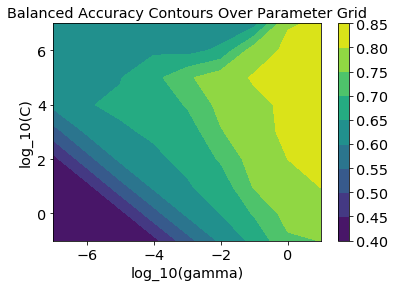

Random state:	 65
Best parameters: {'C': 1000.0, 'gamma': 1.0}
Max opt. balanced accuracy: 0.808
Avg. balanced accuracy:     0.807
Normalized Confusion Matrix
[[0.87 0.11 0.02]
 [0.12 0.72 0.17]
 [0.02 0.14 0.84]]


0.807498632512841

In [122]:
# Run model_opt_exe on clustered organics-only data
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_source, 
                  bin_data=bin_source, 
                  show_opt_plot=True, param_grid=param_grid)

## Randomly augmented data
The remaining models use augmented training data.

In [59]:
# 1:1 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[2,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.714
Median accuracy:  0.715
StdDev accuracy:  0.014
Numer of trials:  30


In [61]:
# 1:2 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 2,
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[3,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.716
Median accuracy:  0.715
StdDev accuracy:  0.012
Numer of trials:  30


In [176]:
# 1:3 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[4,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.716
Median accuracy:  0.715
StdDev accuracy:  0.016
Numer of trials:  30


In [177]:
# 1:4 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[5,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.72
Median accuracy:  0.72
StdDev accuracy:  0.014
Numer of trials:  30


In [203]:
# 1:5 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[6,1:3] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.716
Median accuracy:  0.716
StdDev accuracy:  0.014
Numer of trials:  30


In [ ]:
# 1:10 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[7,1:3] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

In [53]:
# 1:20 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'random', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[8,1:3] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.71
Median accuracy:  0.708
StdDev accuracy:  0.017
Numer of trials:  30
Results:  [0.72, 0.7, 0.69, 0.7, 0.71, 0.71, 0.7, 0.69, 0.73, 0.73, 0.72, 0.71, 0.68, 0.71, 0.7, 0.7, 0.74, 0.72, 0.71, 0.75, 0.7, 0.69, 0.73, 0.72, 0.72, 0.74, 0.72, 0.72, 0.69, 0.69]


## Matching (unsupervised) augmented data

In [65]:
# 1:1 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[2,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.732
Median accuracy:  0.734
StdDev accuracy:  0.008
Numer of trials:  30


In [66]:
# 1:2 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[3,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.719
Median accuracy:  0.718
StdDev accuracy:  0.008
Numer of trials:  30


In [63]:
# 1:3 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[4,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.739
Median accuracy:  0.741
StdDev accuracy:  0.009
Numer of trials:  30


In [67]:
# 1:4 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[5,3:5] = blt.multi_trials(num_trials=30, 
                                           model_params=model_params)

Avg accuracy:     0.735
Median accuracy:  0.736
StdDev accuracy:  0.01
Numer of trials:  30


In [35]:
# 1:5 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=50, 
                 print_results=True, 
                 model_params=model_params)

Avg accuracy:     0.754
Median accuracy:  0.761
StdDev accuracy:  0.013
Numer of trials:  50
Results:  [0.77, 0.74, 0.76, 0.76, 0.75, 0.76, 0.76, 0.76, 0.73, 0.76, 0.75, 0.74, 0.75, 0.74, 0.76, 0.75, 0.72, 0.75, 0.76, 0.73, 0.75, 0.76, 0.76, 0.77, 0.76, 0.75, 0.75, 0.76, 0.76, 0.76, 0.78, 0.76, 0.74, 0.76, 0.76, 0.72, 0.72, 0.76, 0.76, 0.76, 0.76, 0.76, 0.78, 0.76, 0.74, 0.76, 0.77, 0.76, 0.76, 0.76]


(0.754, 0.013)

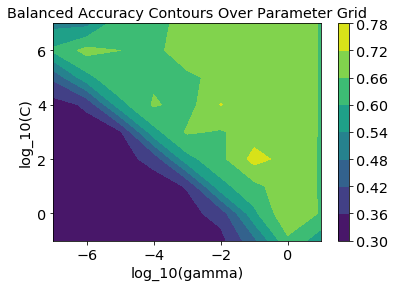

Random state:	 28
Best parameters: {'C': 100.0, 'gamma': 0.1}
Max opt. balanced accuracy: 0.741
Avg. balanced accuracy:     0.761
Normalized Confusion Matrix
[[0.9  0.08 0.02]
 [0.3  0.63 0.07]
 [0.11 0.14 0.76]]


0.76073990657324

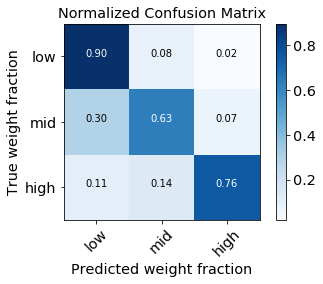

In [25]:
# Single trial SVC-RBF, balanced accuracy
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='uns_match', 
                  k=5, 
                  feat_data=X_enm, 
                  bin_data=bin_enm, 
                  seed=28, 
                  save_fig_name='uns_match', 
                  show_opt_plot=True, 
                  show_feat_impt=False, 
                  show_cnf_matrix=True, 
                  use_balanced_accu=True, # Balanced accuracy 
                  param_grid=param_grid)

In [36]:
match_distrib = [0.77, 0.74, 0.76, 0.76, 0.75, 0.76, 0.76, 0.76, 0.73, 0.76, 
                 0.75, 0.74, 0.75, 0.74, 0.76, 0.75, 0.72, 0.75, 0.76, 0.73, 
                 0.75, 0.76, 0.76, 0.77, 0.76, 0.75, 0.75, 0.76, 0.76, 0.76, 
                 0.78, 0.76, 0.74, 0.76, 0.76, 0.72, 0.72, 0.76, 0.76, 0.76, 
                 0.76, 0.76, 0.78, 0.76, 0.74, 0.76, 0.77, 0.76, 0.76, 0.76]

In [200]:
# 1:10 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[7,3:5] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.751
Median accuracy:  0.754
StdDev accuracy:  0.007
Numer of trials:  30
Results:  [0.75, 0.75, 0.75, 0.75, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.75, 0.75, 0.75, 0.74, 0.76, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.74]


In [57]:
# 1:20 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[8,3:5] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.711
Median accuracy:  0.707
StdDev accuracy:  0.01
Numer of trials:  30
Results:  [0.73, 0.7, 0.71, 0.71, 0.72, 0.72, 0.71, 0.7, 0.73, 0.71, 0.71, 0.71, 0.71, 0.7, 0.71, 0.7, 0.73, 0.72, 0.7, 0.71, 0.69, 0.73, 0.71, 0.71, 0.71, 0.73, 0.71, 0.7, 0.71, 0.71]


## Matching (supervised) augmented data

In [65]:
# 1:1 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[2,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.713
Median accuracy:  0.716
StdDev accuracy:  0.012
Numer of trials:  30


In [15]:
# 1:2 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[3,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.694
Median accuracy:  0.692
StdDev accuracy:  0.008
Numer of trials:  30
Results:  [0.71, 0.68, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7, 0.71, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.7, 0.7, 0.69, 0.69, 0.69, 0.71, 0.69, 0.69, 0.7]


In [20]:
# 1:3 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[4,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.716
Median accuracy:  0.719
StdDev accuracy:  0.007
Numer of trials:  30
Results:  [0.72, 0.7, 0.71, 0.72, 0.72, 0.71, 0.72, 0.69, 0.72, 0.71, 0.72, 0.71, 0.71, 0.72, 0.71, 0.72, 0.72, 0.72, 0.71, 0.7, 0.72, 0.72, 0.72, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.71]


In [22]:
# 1:4 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[5,5:7] = blt.multi_trials(num_trials=30, print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.729
Median accuracy:  0.734
StdDev accuracy:  0.01
Numer of trials:  30
Results:  [0.73, 0.73, 0.73, 0.75, 0.72, 0.75, 0.73, 0.72, 0.73, 0.7, 0.73, 0.73, 0.73, 0.72, 0.73, 0.73, 0.72, 0.73, 0.71, 0.73, 0.72, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.71]


In [24]:
# 1:5 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[6,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.721
Median accuracy:  0.722
StdDev accuracy:  0.007
Numer of trials:  30
Results:  [0.74, 0.72, 0.72, 0.73, 0.72, 0.72, 0.72, 0.71, 0.72, 0.71, 0.72, 0.72, 0.71, 0.72, 0.71, 0.72, 0.72, 0.72, 0.71, 0.72, 0.72, 0.73, 0.72, 0.72, 0.72, 0.72, 0.73, 0.72, 0.72, 0.71]


In [27]:
# 1:10 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[7,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.728
Median accuracy:  0.727
StdDev accuracy:  0.01
Numer of trials:  30
Results:  [0.74, 0.72, 0.71, 0.73, 0.74, 0.73, 0.73, 0.71, 0.73, 0.73, 0.71, 0.71, 0.72, 0.72, 0.73, 0.72, 0.74, 0.75, 0.71, 0.72, 0.73, 0.75, 0.72, 0.73, 0.72, 0.72, 0.73, 0.73, 0.75, 0.73]


In [28]:
# 1:20 ENM:Organics ratio
model_params = {'classifier': 'svc', 
                'aug_type': 'sup_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc.iloc[8,5:7] = blt.multi_trials(num_trials=30, 
                                           print_results=True, 
                                           model_params=model_params)

Avg accuracy:     0.702
Median accuracy:  0.7
StdDev accuracy:  0.01
Numer of trials:  30
Results:  [0.73, 0.7, 0.69, 0.71, 0.71, 0.7, 0.7, 0.7, 0.69, 0.7, 0.69, 0.71, 0.68, 0.69, 0.7, 0.71, 0.7, 0.71, 0.69, 0.72, 0.71, 0.71, 0.71, 0.7, 0.69, 0.7, 0.72, 0.7, 0.69, 0.7]


# Random Forest Models

RFC did not perform as well as SVC in preliminary tests. RFC models here are being used as another way to look at the usefulness (i.e., importance) of different feature groups.

## ENM-only

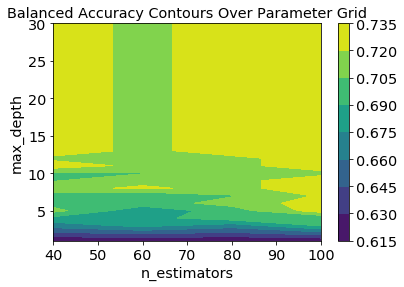

Random state:	 93
Best parameters: {'max_depth': 5, 'n_estimators': 100}
Max opt. balanced accuracy: 0.728
Avg. balanced accuracy:     0.726
Normalized Confusion Matrix
[[0.9  0.06 0.04]
 [0.33 0.44 0.22]
 [0.08 0.08 0.84]]


In [31]:
# Single trial RFC optimizing max_depth and n_estimators (highly variable)
param_grid = {'estimator__max_depth': np.arange(1,31,1), 
              'estimator__n_estimators': np.arange(40,120,20)}
acc, impt = blt.model_opt_exe(classifier='rfc', 
                              aug_type='none', 
                              k=0, 
                              feat_data=X_enm, 
                              bin_data=bin_enm, 
                              show_opt_plot=True, 
                              show_feat_impt=False, 
                              show_cnf_matrix=False, 
                              param_grid=param_grid)

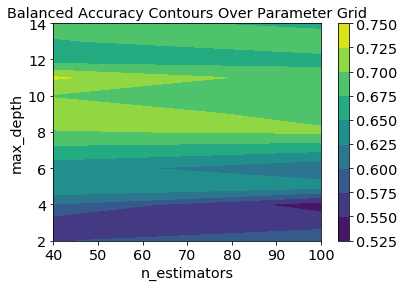

Random state:	 93
Best parameters: {'max_depth': 11, 'n_estimators': 40}
Max opt. balanced accuracy: 0.728
Avg. balanced accuracy:     0.724
Normalized Confusion Matrix
[[0.92 0.06 0.02]
 [0.33 0.44 0.22]
 [0.08 0.11 0.81]]


In [51]:
# Single trial RFC optimizing max_depth and n_estimators (highly variable)
# Smaller parameter grid
param_grid = {'estimator__max_depth': np.arange(2,15,1), 
              'estimator__n_estimators': [40, 100]}
acc, impt = blt.model_opt_exe(classifier='rfc', 
                              aug_type='random', 
                              k=5, 
                              feat_data=X_enm, 
                              bin_data=bin_enm, 
                              show_opt_plot=True, 
                              show_feat_impt=False, 
                              show_cnf_matrix=False, 
                              param_grid=param_grid)

The contour plots for parameter optimization show that balanced accuracy does not vary much by n_estimators, so we will only test two. Balanced accuracy also seems to stop improving at max_depths beyond 10, so the max_depth range will be set from 4 to 14.

In [26]:
# 30 trials RFC optimizing max_depth and n_estimators 
model_params = {'classifier': 'rfc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__max_depth': np.arange(4,12,1), 
                               'estimator__n_estimators': [40,100]}
               }
mu_rfc, sigma_rfc, avg_impt, var_impt = \
    blt.multi_trials(num_trials=30, model_params=model_params)

Avg accuracy:     0.728
Median accuracy:  0.729
StdDev accuracy:  0.013
Numer of trials:  30


In [101]:
# Save results to table
results_rfc.loc[results_rfc['ENM-Organics-Ratio']=='1:0', 
    ['Avg-Random-Augment','Std-Random-Augment']] = [mu_rfc, sigma_rfc]

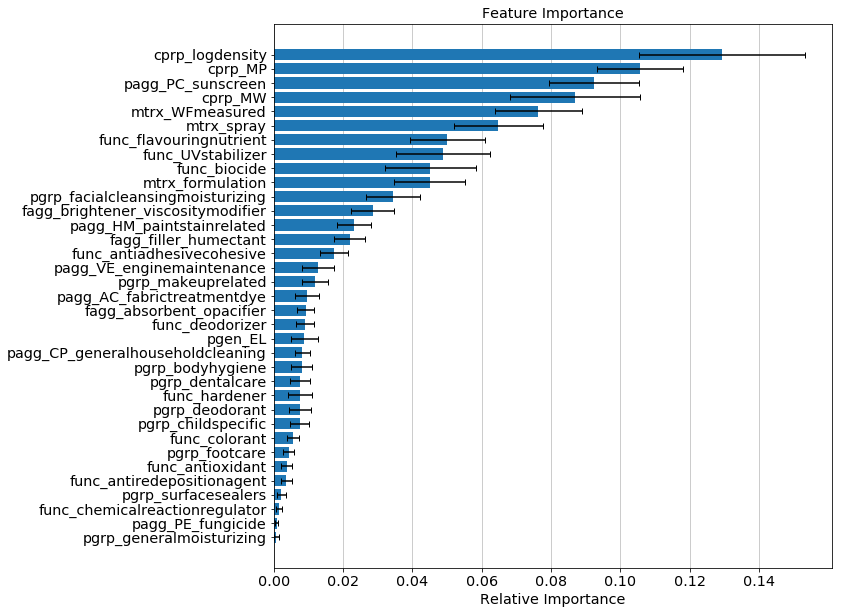

In [31]:
blt.plot_feat_impt(feat_names=X_enm.columns.values, 
                   importances=avg_impt, 
                   save_fig_name='ENM_RFC', 
                   variances=var_impt, 
                   combo_impt=False)

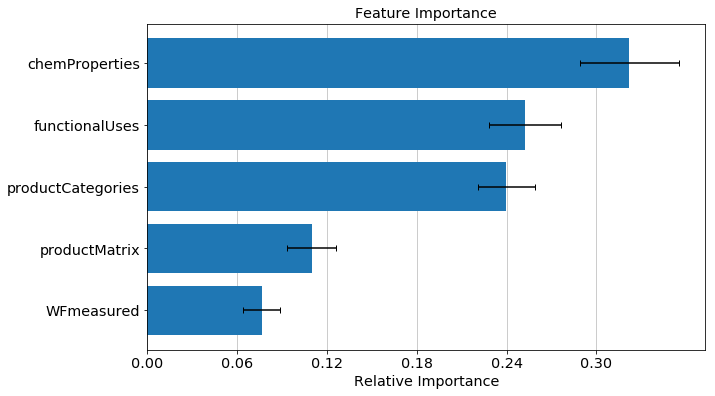

In [34]:
blt.plot_feat_impt(feat_names=X_enm.columns.values, 
                   importances=avg_impt, 
                   save_fig_name='ENM_RFC_combo', 
                   variances=var_impt, 
                   combo_impt=True)

## Randomly augmented data

In [29]:
rfc_param_grid = {'estimator__max_depth': np.arange(4,12,1), 
                  'estimator__n_estimators': [40,100]}

In [42]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[2,1:3] = a, b

Avg accuracy:     0.714
Median accuracy:  0.713
StdDev accuracy:  0.011
Numer of trials:  30


In [43]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[3,1:3] = a, b

Avg accuracy:     0.716
Median accuracy:  0.714
StdDev accuracy:  0.011
Numer of trials:  30


In [44]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[4,1:3] = a, b

Avg accuracy:     0.716
Median accuracy:  0.715
StdDev accuracy:  0.01
Numer of trials:  30


In [45]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[5,1:3] = a, b

Avg accuracy:     0.715
Median accuracy:  0.711
StdDev accuracy:  0.015
Numer of trials:  30


In [46]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[6,1:3] = a, b

Avg accuracy:     0.711
Median accuracy:  0.712
StdDev accuracy:  0.012
Numer of trials:  30


In [104]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[7,1:3] = a, b

Avg accuracy:     0.712
Median accuracy:  0.712
StdDev accuracy:  0.012
Numer of trials:  30


In [66]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[8,1:3] = a, b

Avg accuracy:     0.707
Median accuracy:  0.707
StdDev accuracy:  0.015
Numer of trials:  30


## Matching (unsupervised) augmented data

In [31]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[2,3:5] = a, b

Avg accuracy:     0.713
Median accuracy:  0.711
StdDev accuracy:  0.015
Numer of trials:  30


In [32]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[3,3:5] = a, b

Avg accuracy:     0.71
Median accuracy:  0.71
StdDev accuracy:  0.011
Numer of trials:  30


In [40]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[4,3:5] = a, b

Avg accuracy:     0.712
Median accuracy:  0.713
StdDev accuracy:  0.014
Numer of trials:  30


In [59]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[5,3:5] = a, b

Avg accuracy:     0.71
Median accuracy:  0.707
StdDev accuracy:  0.011
Numer of trials:  30


In [61]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[6,3:5] = a, b

Avg accuracy:     0.706
Median accuracy:  0.705
StdDev accuracy:  0.01
Numer of trials:  30


In [62]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[7,3:5] = a, b

Avg accuracy:     0.706
Median accuracy:  0.704
StdDev accuracy:  0.013
Numer of trials:  30


In [63]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[8,3:5] = a, b

Avg accuracy:     0.704
Median accuracy:  0.701
StdDev accuracy:  0.011
Numer of trials:  30


## Matching (supervised) augmented data

In [42]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[2,5:7] = a, b

Avg accuracy:     0.713
Median accuracy:  0.712
StdDev accuracy:  0.011
Numer of trials:  30
Results:  [0.74, 0.71, 0.72, 0.71, 0.69, 0.71, 0.71, 0.71, 0.71, 0.73, 0.71, 0.72, 0.7, 0.71, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.7, 0.73, 0.72, 0.74, 0.71, 0.71, 0.72, 0.72, 0.7]


In [43]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[3,5:7] = a, b

Avg accuracy:     0.703
Median accuracy:  0.702
StdDev accuracy:  0.012
Numer of trials:  30
Results:  [0.73, 0.69, 0.71, 0.69, 0.7, 0.7, 0.69, 0.7, 0.71, 0.7, 0.71, 0.7, 0.68, 0.7, 0.69, 0.71, 0.7, 0.69, 0.68, 0.7, 0.71, 0.73, 0.69, 0.73, 0.71, 0.7, 0.71, 0.7, 0.72, 0.71]


In [44]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[4,5:7] = a, b

Avg accuracy:     0.706
Median accuracy:  0.707
StdDev accuracy:  0.011
Numer of trials:  30
Results:  [0.73, 0.7, 0.72, 0.71, 0.7, 0.72, 0.7, 0.71, 0.71, 0.71, 0.7, 0.7, 0.71, 0.71, 0.7, 0.71, 0.71, 0.7, 0.69, 0.73, 0.69, 0.7, 0.71, 0.72, 0.71, 0.68, 0.73, 0.7, 0.69, 0.7]


In [45]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[5,5:7] = a, b

Avg accuracy:     0.71
Median accuracy:  0.71
StdDev accuracy:  0.012
Numer of trials:  30
Results:  [0.72, 0.7, 0.73, 0.71, 0.72, 0.71, 0.72, 0.72, 0.7, 0.73, 0.71, 0.7, 0.69, 0.68, 0.7, 0.71, 0.71, 0.72, 0.69, 0.72, 0.7, 0.71, 0.72, 0.72, 0.7, 0.73, 0.72, 0.7, 0.71, 0.71]


In [46]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[6,5:7] = a, b

Avg accuracy:     0.708
Median accuracy:  0.711
StdDev accuracy:  0.012
Numer of trials:  30
Results:  [0.73, 0.71, 0.71, 0.68, 0.7, 0.71, 0.71, 0.68, 0.72, 0.7, 0.71, 0.72, 0.7, 0.72, 0.71, 0.72, 0.72, 0.71, 0.7, 0.74, 0.69, 0.69, 0.71, 0.71, 0.72, 0.71, 0.7, 0.7, 0.7, 0.72]


In [47]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[7,5:7] = a, b

Avg accuracy:     0.708
Median accuracy:  0.707
StdDev accuracy:  0.012
Numer of trials:  30
Results:  [0.71, 0.7, 0.7, 0.7, 0.72, 0.73, 0.72, 0.69, 0.72, 0.7, 0.69, 0.69, 0.69, 0.72, 0.71, 0.71, 0.73, 0.7, 0.7, 0.74, 0.71, 0.71, 0.71, 0.7, 0.72, 0.7, 0.69, 0.71, 0.71, 0.7]


In [57]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[8,5:7] = a, b

Avg accuracy:     0.699
Median accuracy:  0.701
StdDev accuracy:  0.011
Numer of trials:  30
Results:  [0.7, 0.72, 0.7, 0.69, 0.69, 0.7, 0.7, 0.67, 0.72, 0.7, 0.7, 0.69, 0.69, 0.71, 0.68, 0.71, 0.7, 0.7, 0.68, 0.71, 0.69, 0.71, 0.72, 0.68, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]


# Performance Results

The following two table summarize the average balanced accuracy for the 1) SVC-RBF models and 2) RFC models on all training data iterations.
* 'ENM-Organics-Ratio' describes the ratio of ENM data to organics data used for augmentation. 
* An ENM-Organics-Ratio with ( * ) indicates that the labels were randomly permuted
* 'Match-Feature-Augment' is average balanced accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features.
* 'Avg-Unsupervised-Match' is average accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features AND labels (weighted 1:1).
* The second trial (B) of the ENM-only data (1:0 ratio) is with different a different parameter grid for optimizing the SVC-RBF.

Matching augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

## SVC-RBF

In [68]:
# View balanced accuracy results for all models as stylized heatmap
cmap = matplotlib.cm.get_cmap('Wistia')
(results_svc.iloc[:,[0,1,3,5]]
     .set_index('ENM-Organics-Ratio')
     .style
     # Highlight maximum value in row
     .apply(blt.highlight_max, color=blt.rgba2hex(cmap(255)), axis=0)
     .set_precision(3)  # Round decimals
     .set_caption('Average balanced accuracy for SVC-RBF models.')
)

,Avg-Random-Augment,Avg-Unsupervised-Match,Avg-Supervised-Match
ENM-Organics-Ratio,,,
1:0*,0.403,nan,nan
1:0,0.713,nan,nan
1:1,0.714,0.732,0.713
1:2,0.716,0.719,0.694
1:3,0.716,0.739,0.716
1:4,0.72,0.735,0.729
1:5,0.716,0.757,0.721
1:10,0.721,0.751,0.728
1:20,0.71,0.711,0.702


In [69]:
# Export results table to .csv
results_svc.to_csv("./data/results-SVC.csv", 
                  sep='\t', header='infer', na_rep='NaN', index=False)

### Permutation test

In [37]:
# Check normality of test results for permutations, baseline and best models
from scipy.stats import normaltest
for i in [results_permute, base_distrib, match_distrib]:
    print(normaltest(i))

NormaltestResult(statistic=3.5539831224682628, pvalue=0.16914624872107303)
NormaltestResult(statistic=0.2869921840818213, pvalue=0.8663241857401054)
NormaltestResult(statistic=9.937379371120981, pvalue=0.006952251704904397)


The p-value of our first normality test is above alpha=0.05, so it is fairly safe to assume that the permutation test results can be adequately represented by a normal distribution. The distribution for our best augmentation model does not pass, however. So a non-parametric test should be used for that data.

In [38]:
# Get average balanced accuracy for models of interest
mu = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0', 
                     'Avg-Random-Augment'].values
mu_permute = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0*', 
                             'Avg-Random-Augment'].values
mu_match = results_svc.iloc[results_svc['Avg-Unsupervised-Match'].idxmax(), 3]

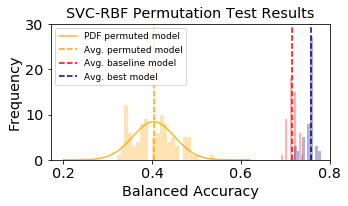

In [123]:
# Plot permutation test results
import numpy as np
from scipy.stats import norm, skewnorm, kurtosis, skew
import matplotlib.pyplot as plt

# Plot histograms
plt.rcParams['font.size'] = 10
plt.hist(results_permute, bins=25, facecolor='orange', alpha=0.3)
plt.hist(base_distrib, facecolor='red', alpha=0.3)
plt.hist(match_distrib, facecolor='navy', alpha=0.3)

# Stats for distributions
std_permute = norm.fit(results_permute)[1]
std_base = norm.fit(base_distrib)[1]
std_match = norm.fit(match_distrib)[1]
x = np.linspace(0.2, 0.62, 100)
x2 = np.linspace(0.62, 0.8, 100)

# Plot PDFs
plt.plot(x, norm.pdf(x, mu_permute, std_permute), 
         color='orange', label='PDF permuted model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu, std_base), 
#         color='red', label='PDF baseline model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu_match, std_match), 
#         color='navy', label='PDF best model', alpha=0.8)

# Plot averages
plt.axvline(mu_permute, ls='--', c='orange', label='Avg. permuted model')
plt.axvline(mu, ls='--', c='red', label='Avg. baseline model')
plt.axvline(mu_match, ls='--', color='navy', label='Avg. best model')

# Figure settings
plt.title("SVC-RBF Permutation Test Results")
plt.xlim(right=0.8)
plt.ylim(top=30)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.legend(loc=2, fontsize=9)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 2.5)
blt.savepdf(fig, 'permutation_test')
plt.show()

As is evident by the frequency plot, both models perform significantly better than the permutation test.

### Significance testing

In [26]:
# Test for significance of paired difference between model distributions
"""
The Wilcoxon signed-rank test is a non-parametric version of the paired T-test.
https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.stats.wilcoxon.html
"""
from scipy.stats import wilcoxon
wilcoxon(x=base_distrib, y=match_distrib) # alternative='two-sided' # alternative='less'

WilcoxonResult(statistic=0.0, pvalue=6.16938292053122e-10)

Our null hypothesis was that the balanced average for our baseline model was the same as that of the best model. The alternative hypothesis is that the baseline model is smaller than the best model. Because the p-value (divided by 2 for a one-tailed test) from the Wilcoxon signed-rank test was incredibly small in comparison to an alpha of 0.05, we can reject the null hypothesis. It is statistically likely that the best model performs better than the baseline.

In [38]:
# Test for significance of paired difference using different feature groups
distrib_base = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]
distrib_noWF = [0.73, 0.7, 0.73, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.73, 0.72, 0.7, 0.72, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.71, 0.72, 0.7]
distrib_noPM = [0.64, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.61, 0.62, 0.63, 0.62, 0.65, 0.61, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]
distrib_unsup1to10 = [0.75, 0.75, 0.75, 0.75, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.75, 0.75, 0.75, 0.74, 0.76, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.74]

In [31]:
# Baseline vs no was_WF_measured
from scipy.stats import wilcoxon
wilcoxon(x=distrib_base, y=distrib_noWF) # alternative='two-sided' # alternative='less'

WilcoxonResult(statistic=110.0, pvalue=0.8434096973782138)

In [32]:
# Baseline vs no PUCs, matrix properties
wilcoxon(x=distrib_base, y=distrib_noPM) 

WilcoxonResult(statistic=0.0, pvalue=1.4760286997863055e-06)

In [39]:
# Baseline vs unsupervised matching augmentation 1:10 ratio
wilcoxon(x=distrib_base, y=distrib_unsup1to10) 

WilcoxonResult(statistic=0.0, pvalue=1.3177185636992911e-06)

## RFC

In [67]:
# View balanced accuracy results for all models as stylized heatmap
cmap = matplotlib.cm.get_cmap('Wistia')
(results_rfc.iloc[:,[0,1,3,5]]
     .set_index('ENM-Organics-Ratio')  # Set table index
     .style
     # Apply heatmap
     .background_gradient(cmap=cmap, low=0, high=0.9, axis=0)
     # Highlight maximum value in row
     .apply(blt.highlight_max, color=blt.rgba2hex(cmap(255)), axis=0)
     # Recolor zeroes
     .applymap(lambda x: blt.recolor_text(x, color=blt.rgba2hex(cmap(0))))
     .set_precision(3)  # Round decimals
     .set_caption('Colormap of average balanced accuracy for RFC models.')
)

,Avg-Random-Augment,Avg-Unsupervised-Match,Avg-Supervised-Match
ENM-Organics-Ratio,,,
1:0*,0,nan,nan
1:0,0.729,nan,nan
1:1,0.714,0.713,0.713
1:2,0.716,0.71,0.703
1:3,0.716,0.712,0.706
1:4,0.715,0.71,0.71
1:5,0.711,0.706,0.708
1:10,0.712,0.706,0.708
1:20,0.707,0.704,0.699


In [68]:
# Export results table to .csv
results_rfc.to_csv("./data/results-RFC.csv", 
                  sep='\t', header='infer', na_rep='NaN', index=False)